In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wg
from scipy.interpolate import interp1d

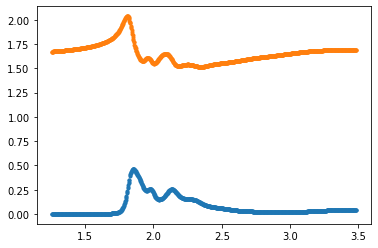

In [5]:
#Load the data

k_static = np.loadtxt('Pentacene/RefFitStuff/PC_k.txt',delimiter = ',')
n_static = np.loadtxt('Pentacene/RefFitStuff/PC_n.txt',delimiter = ',')

#Add zeros subgap
energy_subgap = np.linspace(min(k_static[:,0] ),min(n_static[:,0]),30)
k_zeros_subgap =np.zeros(30)

k_x = np.asarray(np.append(energy_subgap,k_static[:,0]))
k_y = np.asarray(np.append(k_zeros_subgap,k_static[:,1]))
k_static = np.transpose(np.asarray([k_x,k_y]))


e_lb = max(min(k_static[:,0]),min(n_static[:,0]))
e_ub = min(max(k_static[:,0]),max(n_static[:,0]))
W = 1000

energy = np.linspace(e_lb,e_ub,W)
k = interp1d(k_static[:,0],k_static[:,1] ,kind='linear')
ky = k(energy)
n = interp1d(n_static[:,0],n_static[:,1] ,kind='linear')
ny = n(energy)


k_static=np.transpose(np.asarray([energy,ky]))
n_static=np.transpose(np.asarray([energy,ny]))


plt.figure()
plt.plot(k_static[:,0],k_static[:,1],'.')
plt.plot(n_static[:,0],n_static[:,1],'.')
plt.show()


In [7]:
#initialise guess as 0s before we start fitting
N_osc = 6
c_guess = [0] * (N_osc*3 )
eps_inf_fin =[0]

c_guess =[0.469,1.85,0.074,0.363,1.974,0.111,0.372,2.123,0.109,0.462,2.293,0.27,0.578,3.462,0.541,0.83,4.157,1.259]
eps_inf_fin = [2.541]

# c_guess=xf[1:]
# eps_inf_fin=[xf[0]]



<IPython.core.display.Javascript object>


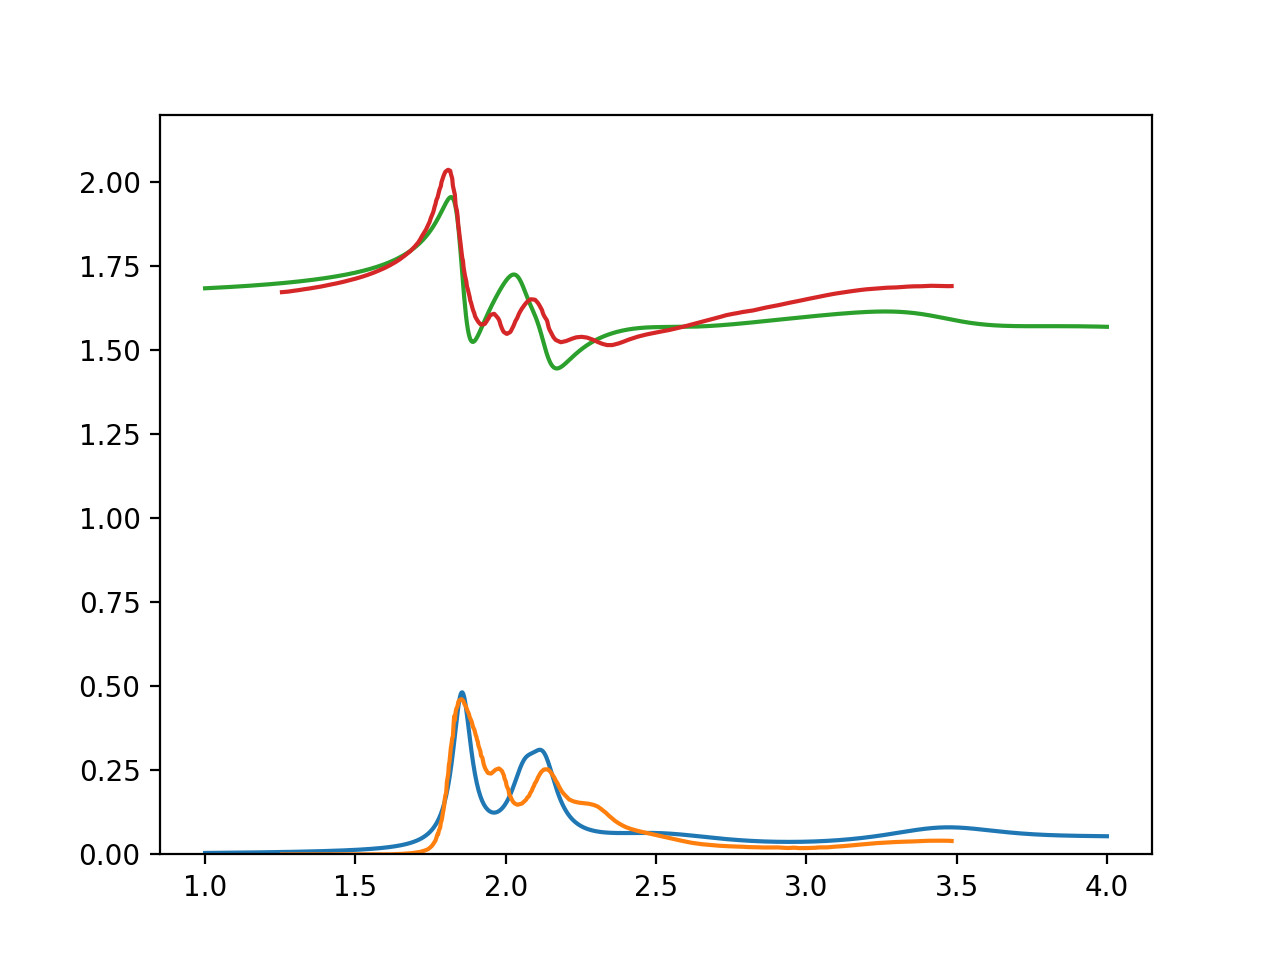

Controlling Oscillator number  4


interactive(children=(FloatSlider(value=2.556, description='eps_inf', max=5.0, step=0.001), FloatSlider(value=…

<function __main__.update(eps_inf=FloatSlider(value=2.556, description='eps_inf', max=5.0, step=0.001), wp=FloatSlider(value=0.462, description='wp', max=10.0, min=0.1, step=0.001), w0=FloatSlider(value=2.293, description='w0', max=10.0, min=1.0, step=0.001), g=FloatSlider(value=0.27, description='g', max=2.0, min=0.04, step=0.001))>

In [9]:
#Fit initial fit guess by hand

%matplotlib notebook

e_grid =1000

e_min=1
e_max=4

wp_min=.1
wp_max=10
w0_min =1
w0_max =10
g_min = 40e-3
g_max = 2
eps_inf_max = 5
eps_inf_min= 0

#Initialise parameters

i=0
params_init=[]
while i<N_osc:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess


#Initialise slider

i=0
wp_slide=[]

while i<N_osc:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .001,value =c_guess[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .001,value =c_guess[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .001,value =c_guess[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
   
    i=i+1
    
eps_slide = wg.FloatSlider(min=eps_inf_min,max=eps_inf_max,step= .001,value = eps_inf_fin[0])



w=np.linspace(e_min,e_max,e_grid)

def LorentzOsc(w,wp,w0,g):
    return wp**2/(w0**2 - w**2 - 1j*w*g)

def DF(w,eps_inf,params,N_osc):
    i=0
    x = np.zeros(e_grid)
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc:
        x = x+LorentzOsc(w,wp[i],w0[i],g[i])
        i=i+1
    return x + eps_inf    

    
    
osc_num = 4

i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


    
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line_k, = ax.plot(w,np.imag(np.sqrt(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))
line_k_data = ax.plot(k_static[:,0],k_static[:,1])
line_n, = ax.plot(w,np.real(np.sqrt(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))
line_n_data = ax.plot(n_static[:,0],n_static[:,1])
ax.set_ylim(0,2.2)




def update(eps_inf = eps_slide, wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g]):
    line_k.set_ydata(np.imag(np.sqrt(DF(w,eps_inf ,c_guess,N_osc))))
    line_n.set_ydata(np.real(np.sqrt(DF(w,eps_inf ,c_guess,N_osc))))
    c_guess[i_wp] = wp
    c_guess[i_w0] = w0
    c_guess[i_g] =  g
    eps_inf_fin[0] = eps_inf
    fig.canvas.draw_idle()


    

print('Controlling Oscillator number ', osc_num)   
wg.interact(update)







In [10]:
#LM Fitting



def residues(c_guess,data_k,data_n):
    return (np.imag(np.sqrt(DF(data_k[:,0],c_guess[0],c_guess[1:],N_osc))) - data_k[:,1])**2  + (np.real(np.sqrt(DF(data_n[:,0],c_guess[0],c_guess[1:],N_osc))) - data_n[:,1])**2
    
    
def de2bwp(w,wp,w0,g):
    return (2*g*w*wp)/((w0**2-w**2)+(g**2)*(w**2))

def de2bw0(w,wp,w0,g):
    return (-4*g*(wp**2)*w0*w*(w0**2-w**2))/(((g**2)*(w**2)) + ((w0**2 -w**2)**2)**2)

def de2bg(w,wp,w0,g):
    return (w*(wp**2)*(w**4 - (w**2)*(2*w0**2+g**2) +w0**4))/((((g**2)*(w**2)) + ((w0**2 -w**2)**2))**2)

def de1beinf(w):
    return w/w

def de1bwp(w,wp,w0,g):
    return (2*wp*(w0**2 -w**2))/((w0**2-w**2)+((g**2)*(w**2)))

def de1bw0(w,wp,w0,g):
    return (-2*(wp**2)*w0*((-(g**2)*(w**2))+w0**4 - (2*(w0**2)*(w**2)) + w**4))/((((g**2)*(w**2))+w0**4 - (2*(w0**2)*(w**2)) +w**4)**2)

def de1bg(w,wp,w0,g):
    return (-2*g*(w**2)*(wp**2)*(w0**2 - w**2))/((((g**2)*(w**2)) + (w**2 - w0**2)**2)**2)
    

def dsqrtDF(c_guess,data_k,data_n):
    i=0
    eps_inf = c_guess[0] 
    params= c_guess[1:]                            
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    w = data_k[:,0]
    J = []
    IF =1/(2*np.sqrt(DF(w,c_guess[0],c_guess[1:],N_osc)))
    J=[]
    while i<(N_osc):
        J_temp = (IF*([de1bwp(w,wp[i],w0[i],g[i]) +1j*de2bwp(w,wp[i],w0[i],g[i]),de1bw0(w,wp[i],w0[i],g[i]) +1j*de2bw0(w,wp[i],w0[i],g[i]),de1bg(w,wp[i],w0[i],g[i]) +1j*de2bg(w,wp[i],w0[i],g[i])]))
        J=np.append(J,J_temp)
        i=i+1
    J = np.append(de1beinf(w),J) 
    J = np.asarray(J)
    J = np.reshape(J,(3*N_osc + 1,np.shape(w)[0]))
    return np.transpose(np.real(J))


upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc)
upper_bounds = np.append(eps_inf_max,upper_bounds)

lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc)
lower_bounds = np.append(eps_inf_min,lower_bounds)

bounds = np.asarray((lower_bounds,upper_bounds))

x0 = np.append(eps_inf_fin[0],c_guess)
xf = optimize.least_squares(residues,x0, bounds=bounds,args=(k_static,n_static))#,Dfun = dsqrtDF,col_deriv=1)
xf=xf.x  

    

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


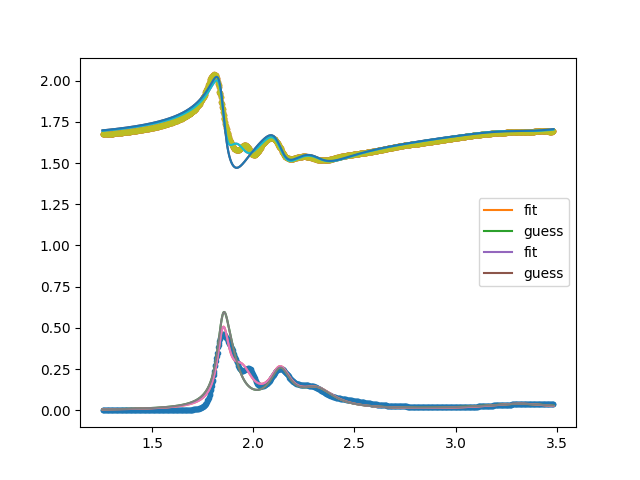

In [55]:
plt.figure()
plt.plot(k_static[:,0],k_static[:,1],'.')
plt.plot(k_static[:,0],np.imag(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc))),label='fit')
plt.plot(n_static[:,0],np.imag(np.sqrt(DF(n_static[:,0],x0[0],x0[1:],N_osc))),label='guess')
plt.plot(n_static[:,0],n_static[:,1],'.')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc))),label='fit')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],x0[0],x0[1:],N_osc))),label='guess')
plt.legend()
plt.show()



In [56]:
#Implement variational diabolical oscillator

def g(a,b):
    return ((a+b)*np.log(np.abs(a+b))) + ((a-b)*np.log(np.abs(a-b)))

def diabolical_osc_re(w,wc,delta):
    return np.piecewise(w, [w!= wc,w==wc],
                        [lambda w: (1/np.pi)*((g(w,wc-delta)/(delta)) - (((2*delta)*g(w,wc))/((delta)*(delta))) + (g(w,wc+delta)/delta)),0])

def diabolical_osc_im(w,wc,delta):
    return np.piecewise(w,[np.logical_and((wc) <= w ,w <= (wc+ delta)),
                           np.logical_and((wc-delta) < w ,w < (wc)),
                           np.logical_and((wc-delta) > w ,w > (wc+delta))],
                           [lambda w:(wc+ delta - w)/(delta),
                            lambda w:(w-(wc-delta))/(delta),
                            lambda w:0])

def diabolical_osc(w,wc,delta):
    return diabolical_osc_re(w,wc,delta) + 1j*diabolical_osc_im(w,wc,delta)
    



In [116]:
#Implement total variational dielectric function 

N_var_osc = 500
delta = (max(k_static[:,0]) - min(k_static[:,0]))/(N_var_osc)
wc = np.linspace(min(k_static[:,0])+ delta/2,max(k_static[:,0])- delta/2,N_var_osc)

residuals_k = (k_static[:,1] - np.imag(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc))))
A_0_interp_k = interp1d(k_static[:,0],residuals_k,kind='linear')

A_0_k = A_0_interp_k(wc)


# residuals_n = (n_static[:,1] - np.real(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc))))
# A_0_interp_n = interp1d(n_static[:,0],residuals_n,kind='linear')

# A_0_n = A_0_interp_n(wc)


A_0 = (A_0_k)/2




plt.plot(k_static[:,0],np.imag(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc))),label='fit')
plt.plot(n_static[:,0],np.imag(np.sqrt(DF(n_static[:,0],x0[0],x0[1:],N_osc))),label='guess')
plt.plot(n_static[:,0],n_static[:,1],'.')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc))),label='fit')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],x0[0],x0[1:],N_osc))),label='guess')

def DiabolicalDF(w,A,wc,delta,N_var_osc):
    i=0
    x = np.zeros(e_grid)
    while i<N_var_osc:
        x = x+ A[i]*diabolical_osc(w,wc[i],delta)
        i=i+1
    return x 



def derivTotalVariationalnk(A,data_k,data_n,delta,wc):
    i=0
    x = np.zeros(e_grid)
    wc =wc
    delta = delta
    A = A
    eps = DF(data_k[:,0],xf[0],xf[1:],N_osc) + DiabolicalDF(data_k[:,0],A,wc,delta,N_var_osc)
    J=[]
    IF_im =(np.imag(np.sqrt(eps)) - data_k[:,1])*np.imag(diabolical_osc(data_k[:,0],wc[i],delta)/np.sqrt(eps))
    IF_re =(np.real(np.sqrt(eps)) - data_n[:,1])*np.real(diabolical_osc(data_k[:,0],wc[i],delta)/np.sqrt(eps))
    while i<N_var_osc:
        J_temp = IF_im + IF_re
        J=np.append(J,J_temp)
        i=i+1
    J = np.asarray(J)
    J = np.reshape(J,(N_var_osc,np.shape(w)[0]))
    return np.transpose(J) 





def residues_var(A,data_k,data_n,delta,wc):
    eps = DF(data_k[:,0],xf[0],xf[1:],N_osc) + DiabolicalDF(data_k[:,0],A,wc,delta,N_var_osc)
    return (np.imag(np.sqrt(eps)) - data_k[:,1])**2  + (np.real(np.sqrt(eps)) - data_n[:,1])**2
    

Af = optimize.least_squares(residues_var,A_0,method = 'lm',jac = derivTotalVariationalnk, args=(k_static,n_static,delta,wc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)
#Af = optimize.least_squares(residues_var,A_0, args=(k_static,n_static,delta,wc),verbose=2)



Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 52, initial cost 4.6131e-04, final cost 4.6010e-04, first-order optimality 3.88e-05.


<IPython.core.display.Javascript object>


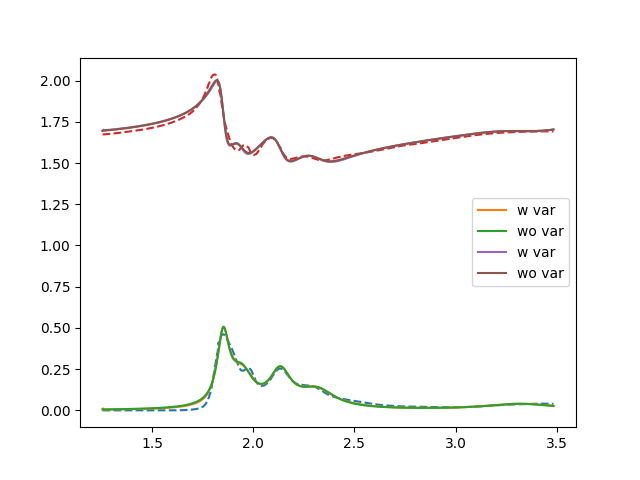

In [117]:
plt.figure()
plt.plot(k_static[:,0],k_static[:,1],linestyle = '--')
plt.plot(k_static[:,0],np.imag(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc)+DiabolicalDF(k_static[:,0],Af.x,wc,delta,N_var_osc))),label='w var')
plt.plot(n_static[:,0],np.imag(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc))),label='wo var')
plt.plot(n_static[:,0],n_static[:,1],linestyle = '--')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc)+DiabolicalDF(k_static[:,0],Af.x,wc,delta,N_var_osc))),label='w var')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc))),label='wo var')
plt.legend()
plt.show()




In [118]:
Af.x

array([ 2.10991617e-02, -3.90843959e-03, -3.94401189e-03, -3.98022284e-03,
       -4.01708927e-03, -4.05462860e-03, -4.09285884e-03, -4.13179862e-03,
       -4.17146723e-03, -4.21188464e-03, -4.25307153e-03, -4.29504933e-03,
       -4.33784022e-03, -4.38146721e-03, -4.42595415e-03, -4.47132578e-03,
       -4.51760775e-03, -4.56482670e-03, -4.61301027e-03, -4.66218715e-03,
       -4.71238716e-03, -4.76364129e-03, -4.81598172e-03, -4.86944194e-03,
       -4.92405677e-03, -4.97986246e-03, -5.03689671e-03, -5.09519881e-03,
       -5.15480966e-03, -5.21577191e-03, -5.27812999e-03, -5.34193027e-03,
       -5.40722110e-03, -5.47405296e-03, -5.54247857e-03, -5.61255300e-03,
       -5.68433380e-03, -5.75788114e-03, -5.83325798e-03, -5.91053020e-03,
       -5.98976679e-03, -6.07104002e-03, -6.15442564e-03, -6.24000309e-03,
       -6.32785571e-03, -6.41807099e-03, -6.51074084e-03, -6.60596183e-03,
       -6.70383554e-03, -6.80446881e-03, -6.90797415e-03, -7.01447007e-03,
       -7.12408149e-03, -

<IPython.core.display.Javascript object>


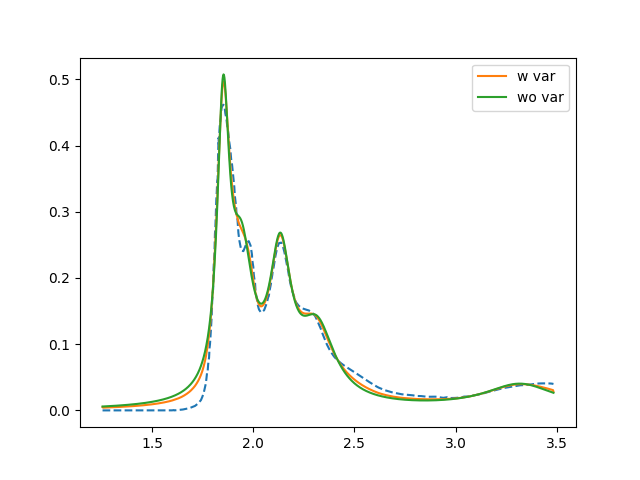

<IPython.core.display.Javascript object>


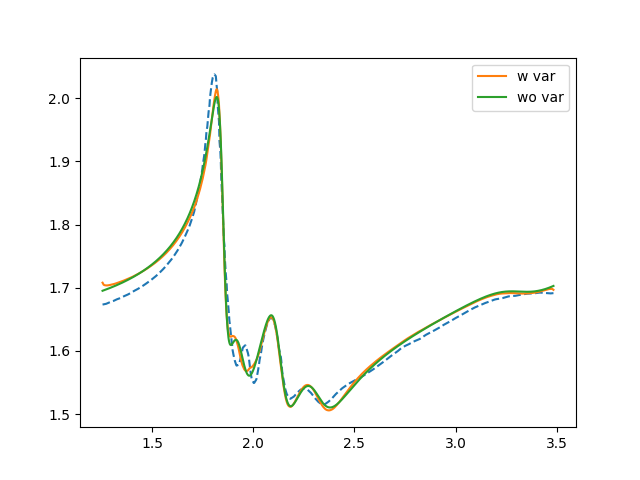

In [122]:
residuals_k = (k_static[:,1] - np.imag(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc))))
A_0_interp_k = interp1d(k_static[:,0],residuals_k,kind='linear')

A_0_k = A_0_interp_k(wc)


residuals_n = (n_static[:,1] - np.real(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc))))
A_0_interp_n = interp1d(n_static[:,0],residuals_n,kind='linear')

A_0_n = A_0_interp_n(wc)




plt.figure()
plt.plot(k_static[:,0],k_static[:,1],linestyle = '--')
plt.plot(k_static[:,0],np.imag(np.sqrt(DF(k_static[:,0],xf[0],xf[1:],N_osc)+DiabolicalDF(k_static[:,0],A_0_k,wc,delta,N_var_osc))),label='w var')
plt.plot(n_static[:,0],np.imag(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc))),label='wo var')
plt.legend()
plt.show()


plt.figure()
plt.plot(n_static[:,0],n_static[:,1],linestyle = '--')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc)+DiabolicalDF(k_static[:,0],A_0_n,wc,delta,N_var_osc))),label='w var')
plt.plot(n_static[:,0],np.real(np.sqrt(DF(n_static[:,0],xf[0],xf[1:],N_osc))),label='wo var')
plt.legend()
plt.show()







